In [6]:
import pandas as pd
from pymrmre import mrmr
from itertools import chain
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore')
# CV Source: https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/ 
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import accuracy_score

In [16]:
## Helper functions
def prep_genomics(df):
    ''' Bring raw Genomics into right format '''
    df.set_index("Unnamed: 0", inplace=True)
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={"index":"oncotech_id"})
    return df

def use_median_to_build_classes(df, predictor):
    ''' Add column of classes for predictor to dataframe
            Class 0 if value smaller/equal to median
            Class 1 if greather median
    '''
    df["class_"+predictor] = 4
    df["class_"+predictor][df[predictor] <= df[predictor].median()] = 0
    df["class_"+predictor][df[predictor] > df[predictor].median()] = 1
    return df

def get_feat_mrmr(df, y, nr_feat, solution_count):
    ''' Feature filtering using MRMR '''
    y = pd.DataFrame(y)
    solutions = mrmr.mrmr_ensemble(features = df, targets = y, solution_length = nr_feat, solution_count = solution_count)
    return solutions

def get_binary_feats(df, predictor):
    gene_names = list(df.columns)[:-1]
    df_genes_only = df[gene_names]

    comp_df = pd.DataFrame(index=range(len(df)))
    comp_df["class_"+predictor] = df["class_"+predictor]
    for i in range(len(gene_names)):
        for j in range(len(gene_names)):
            if i == j:
                continue
            #print(i, j)
            gene1 = df_genes_only.iloc[:,i]
            gene2 = df_genes_only.iloc[:,j]
            comp_df[gene1.name + "<" + gene2.name] = gene1 < gene2
            comp_df[gene1.name + "<" + gene2.name] = comp_df[gene1.name + "<" + gene2.name].astype(int)
            comp_df[gene1.name + ">" + gene2.name] = gene1 > gene2
            comp_df[gene1.name + ">" + gene2.name] = comp_df[gene1.name + ">" + gene2.name].astype(int)
    return comp_df

In [26]:
def get_train_test_error(predictor, nr_features_mrmr, nr_solutions_mrmr, cv_splits, n_repeats_cv, random_state):
    # Load raw Genomics data and bring into right format
    disc_genes = prep_genomics(pd.read_csv("../../Data/Discovery-GenomicsTop1000-March22023.csv"))
    # Load Clinical data of discovery set
    disc_clinic = pd.read_csv("../../Data/Discovery-ClinicalData.csv")
    # Add class for continuous value (median)
    disc_clinic = use_median_to_build_classes(disc_clinic, predictor)
    # Merge class to genomics data
    disc_genes = disc_genes.merge(disc_clinic[["oncotech_id", "class_"+predictor]], on="oncotech_id")

    # save names of the genes
    gene_names = disc_genes.columns[1:-1]

    ################### MRMR
    # Run MRMR for feature filtering
    solutions = get_feat_mrmr(disc_genes[gene_names], disc_genes["class_"+predictor], nr_feat=nr_features_mrmr, solution_count=nr_solutions_mrmr)
    # all unique feature mrmr returns
    unique_selected_feats = list(set(list(chain.from_iterable(solutions[0]))))
    print("MRMR with {} features for each of the {} solutions comes out with {} unique genes/features.".format(nr_features_mrmr, nr_solutions_mrmr, len(unique_selected_feats)))


    #################### Get binary feats
    disc_genes_selected = disc_genes[unique_selected_feats + ["class_"+predictor]]
    disc_binary_feats = get_binary_feats(disc_genes_selected, predictor)
    binary_features = list(disc_binary_feats.columns[1:])

    #################### Training repeated CV
    # dataset
    X, y = disc_binary_feats[binary_features], disc_binary_feats["class_"+predictor]
    # create model
    model = LogisticRegression()

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=cv_splits, n_repeats=n_repeats_cv, random_state=random_state)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    train_mean_acc = mean(scores)
    train_std_acc = std(scores)
    #print('Training Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

    # Fit model to complete training set
    model.fit(X,y)


    ########################################################
    ################### Validation Set 
    # Load raw Genomics data and bring into right format
    vali_genes = prep_genomics(pd.read_csv("../../Data/ValidationIUCPQ-March2 2023.csv"))
    # Load Clinical data of discovery set
    vali_clinic = pd.read_csv("../../Data/ValidationClinicalData.csv")
    # Add class for continuous value (median)
    vali_clinic = use_median_to_build_classes(vali_clinic, predictor)
    # Merge class to genomics data
    vali_genes = vali_genes[["oncotech_id"] + unique_selected_feats].merge(vali_clinic[["oncotech_id", "class_"+predictor]], on="oncotech_id")
    
    # Transform to binary features
    vali_genes_selected = vali_genes[unique_selected_feats + ["class_"+predictor]]
    vali_binary_feats = get_binary_feats(vali_genes_selected, predictor)

    vali_predictions = model.predict(vali_binary_feats[binary_features])
    y_pred = vali_predictions
    y_true = vali_binary_feats["class_"+predictor]
    test_acc = accuracy_score(y_true, y_pred)
    # Have training and test score at same position:
    print('Training Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Testing Accuracy: %.3f' % (accuracy_score(y_true, y_pred)))

    return train_mean_acc, train_std_acc, test_acc


In [27]:
# Select the clinical endpoint to predict
predictor = "pfs_days"
nr_features_mrmr = 10
nr_solutions_mrmr = 5

cv_splits = 5
n_repeats_cv = 10
random_state = 42

In [19]:
train_mean_acc, train_std_acc, test_acc = get_train_test_error(predictor, nr_features_mrmr, nr_solutions_mrmr, cv_splits, n_repeats_cv, random_state)

MRMR with 10 features for each of the 5 solutions comes out with 13 unique genes/features.
Training Accuracy: 0.699 (0.112)
Training Accuracy: 0.699 (0.112)
Testing Accuracy: 0.542


In [28]:
# loop through parameters:
predictors = ["os_days", "pfs_days"]
nrs_features_mrmr = [5, 10, 20]
nrs_solutions_mrmr = [3, 5, 10]

_cv_splits = [5, 10]
_n_repeated_cv = [3, 5, 10]
random_state = 42

results_df = pd.DataFrame(columns=["predictor", "nr_features_mrmr", "nr_solutions_mrmr", "cv_splits", "n_repeats_cv", "train_mean_acc", "train_std_acc", "test_acc"])
for predictor in predictors:
    for nr_features_mrmr in nrs_features_mrmr:
        for nr_solutions_mrmr in nrs_solutions_mrmr:
            for cv_splits in _cv_splits:
                for n_repeats_cv in _n_repeated_cv:
                    settings_dict = dict(zip(["predictor", "nr_features_mrmr", "nr_solutions_mrmr", "cv_splits", "n_repeats_cv"], [predictor, nr_features_mrmr, nr_solutions_mrmr, cv_splits, n_repeats_cv]))
                    
                    train_mean_acc, train_std_acc, test_acc = get_train_test_error(predictor, nr_features_mrmr, nr_solutions_mrmr, cv_splits, n_repeats_cv, random_state)
                    settings_dict["train_mean_acc"] = train_mean_acc
                    settings_dict["train_std_acc"] = train_std_acc
                    settings_dict["test_acc"] = test_acc
                    results_df = pd.concat([results_df, pd.DataFrame(settings_dict, index=[0])])
                    

MRMR with 5 features for each of the 3 solutions comes out with 8 unique genes/features.
Training Accuracy: 0.733 (0.081)
Testing Accuracy: 0.458
MRMR with 5 features for each of the 3 solutions comes out with 8 unique genes/features.
Training Accuracy: 0.734 (0.114)
Testing Accuracy: 0.458
MRMR with 5 features for each of the 3 solutions comes out with 8 unique genes/features.
Training Accuracy: 0.741 (0.106)
Testing Accuracy: 0.458
MRMR with 5 features for each of the 3 solutions comes out with 8 unique genes/features.
Training Accuracy: 0.763 (0.127)
Testing Accuracy: 0.458
MRMR with 5 features for each of the 3 solutions comes out with 8 unique genes/features.
Training Accuracy: 0.747 (0.156)
Testing Accuracy: 0.458
MRMR with 5 features for each of the 3 solutions comes out with 8 unique genes/features.
Training Accuracy: 0.752 (0.152)
Testing Accuracy: 0.458
MRMR with 5 features for each of the 5 solutions comes out with 12 unique genes/features.
Training Accuracy: 0.774 (0.091)
T

/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.723 (0.102)
Testing Accuracy: 0.508
MRMR with 10 features for each of the 10 solutions comes out with 18 unique genes/features.
Training Accuracy: 0.742 (0.158)
Testing Accuracy: 0.508
MRMR with 10 features for each of the 10 solutions comes out with 18 unique genes/features.
Training Accuracy: 0.721 (0.166)
Testing Accuracy: 0.508
MRMR with 10 features for each of the 10 solutions comes out with 18 unique genes/features.
Training Accuracy: 0.719 (0.157)
Testing Accuracy: 0.508
MRMR with 20 features for each of the 3 solutions comes out with 22 unique genes/features.
Training Accuracy: 0.699 (0.094)
Testing Accuracy: 0.492
MRMR with 20 features for each of the 3 solutions comes out with 22 unique genes/features.
Training Accuracy: 0.711 (0.093)
Testing Accuracy: 0.492
MRMR with 20 features for each of the 3 solutions comes out with 22 unique genes/features.
Training Accuracy: 0.692 (0.121)
Testing Accuracy: 0.492
MRMR with 20 features for each of the 3 solutions co

/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.713 (0.059)
Testing Accuracy: 0.525
MRMR with 20 features for each of the 5 solutions comes out with 23 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Training Accuracy: 0.714 (0.073)
Testing Accuracy: 0.525
MRMR with 20 features for each of the 5 solutions comes out with 23 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Training Accuracy: 0.691 (0.100)
Testing Accuracy: 0.525
MRMR with 20 features for each of the 5 solutions comes out with 23 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.709 (0.166)
Testing Accuracy: 0.525
MRMR with 20 features for each of the 5 solutions comes out with 23 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Training Accuracy: 0.719 (0.155)
Testing Accuracy: 0.525
MRMR with 20 features for each of the 5 solutions comes out with 23 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Training Accuracy: 0.706 (0.166)
Testing Accuracy: 0.525
MRMR with 20 features for each of the 10 solutions comes out with 26 unique genes/features.
Training Accuracy: 0.681 (0.087)
Testing Accuracy: 0.542
MRMR with 20 features for each of the 10 solutions comes out with 26 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.675 (0.096)
Testing Accuracy: 0.542
MRMR with 20 features for each of the 10 solutions comes out with 26 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.658 (0.123)
Testing Accuracy: 0.542
MRMR with 20 features for each of the 10 solutions comes out with 26 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.664 (0.171)
Testing Accuracy: 0.542
MRMR with 20 features for each of the 10 solutions comes out with 26 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.659 (0.159)
Testing Accuracy: 0.542
MRMR with 20 features for each of the 10 solutions comes out with 26 unique genes/features.


/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/iucpq/Documents/IUCPQ/Environments/venv1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Training Accuracy: 0.658 (0.166)
Testing Accuracy: 0.542


In [35]:
results_df.reset_index(inplace=True)

In [39]:
os_results = results_df[results_df.predictor == "os_days"]

<AxesSubplot: >

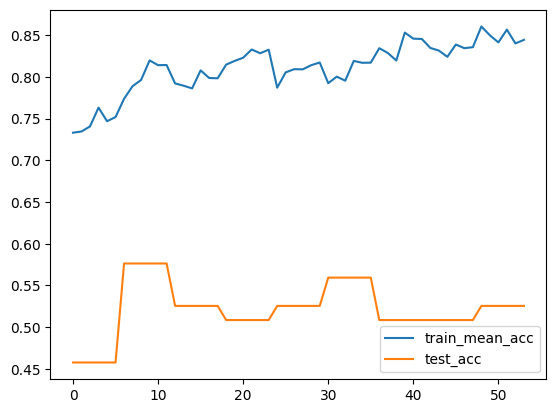

In [40]:
os_results[["train_mean_acc", "test_acc"]].plot()